In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## import metrics from sklearn
from sklearn import metrics
from time import time

## Get DT Classifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score

## Import Logistic Regression from sklearn -- New One --
from sklearn.linear_model import LogisticRegression

## Ensemble models from sklearn for Decision Trees
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [2]:
df = pd.read_excel('customer_churn.xlsx')

# Cleaning function

In [3]:
 df.columns = (df.columns
               .str.replace('\s','_',regex=True)
               .str.lower()
               .copy()
               )

In [4]:
## All these have been checked to be binary first

df.gender = df.gender.map({'Male':0,'Female':1})
df.senior_citizen = df.senior_citizen.map({'No':0,'Yes':1})
df.partner = df.partner.map({'No':0,'Yes':1})
df.dependents = df.dependents.map({'No':0,'Yes':1})
df.phone_service = df.phone_service.map({'No':0,'Yes':1})
df.paperless_billing = df.paperless_billing.map({'No':0,'Yes':1})

## Rename gender to sex
df.rename(columns={'gender':'sex'},inplace=True)

In [5]:
df=pd.get_dummies(data = df, columns = ['multiple_lines','internet_service','online_security','online_backup','device_protection','tech_support','streaming_movies','streaming_tv','contract','payment_method'], drop_first=True)

# Split

In [6]:
## Feature columns

Features = [
    'tenure_months',
    'internet_service_Fiber optic',
    'contract_Two year',
    'payment_method_Electronic check',
    'dependents',
    'streaming_movies_No internet service',
    'device_protection_No internet service',
    'online_security_No internet service',
    'internet_service_No',
    'online_backup_No internet service',
    'churn_value'
]

In [7]:
X=df[Features].copy()

In [8]:
y= X['churn_value']

X.drop(columns=['churn_value'], inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Feature Engineering function

In [10]:
# X_train=pd.get_dummies(data = X_train, columns = ['multiple_lines','internet_service','online_security','online_backup','device_protection','tech_support','streaming_movies','streaming_tv','contract','payment_method'], drop_first=True)

In [11]:
# ## New list without the space values, so the mean can be calculated
# space=X_train.loc[X_train['total_charges']!=' '][['total_charges']]
#
# ## Find the mean
# space_mean=np.mean(space['total_charges'])
#
# ## Apply mean to the ' ' values
# X_train['total_charges']=X_train['total_charges'].replace(' ',space_mean)
#
# ## Change datatype to float
# X_train = X_train.astype({'total_charges':'float'})

# Logistic Regression

## Train

In [12]:
# Calculate class weights
total_samples = len(df)
class_0_count = 5174
class_1_count = 1869
class_0_weight = total_samples / class_0_count ##0.68     ##3518.32
class_1_weight = total_samples / class_1_count ##1.88     ##3513.71

# Create a dictionary with the class weights
class_weights = {0: class_0_weight, 1: class_1_weight}

In [13]:

lr = LogisticRegression(max_iter=250, random_state=42,class_weight=class_weights)

In [14]:
lr.fit(X_train,y_train)

LogisticRegression(class_weight={0: 1.3612292230382683, 1: 3.7683253076511503},
                   max_iter=250, random_state=42)

In [15]:
X_train[['prob_stay' #0
    ,'prob_churn' #1
         ]] = lr.predict_proba(X_train)

In [16]:
X_train['y_pred']=np.where(X_train['prob_churn']>0.5,1,0)

In [17]:
X_train.head()

,tenure_months,internet_service_Fiber optic,contract_Two year,payment_method_Electronic check,dependents,streaming_movies_No internet service,device_protection_No internet service,online_security_No internet service,internet_service_No,online_backup_No internet service,prob_stay,prob_churn,y_pred
2142,71,1,0,0,0,0,0,0,0,0,0.705951,0.294049,0
1623,16,1,0,0,0,0,0,0,0,0,0.238967,0.761033,1
6074,32,1,0,0,0,0,0,0,0,0,0.362022,0.637978,1
1362,24,0,0,0,0,0,0,0,0,0,0.553378,0.446622,0
6754,20,0,0,0,1,1,1,1,1,1,0.923628,0.076372,0


# Test

Feature Engineer Test

In [18]:
# X_test=pd.get_dummies(data = X_test, columns = ['multiple_lines','internet_service','online_security','online_backup','device_protection','tech_support','streaming_movies','streaming_tv','contract','payment_method'], drop_first=True)

In [19]:
# ## Apply mean to the ' ' values
# X_test['total_charges']=X_test['total_charges'].replace(' ',space_mean)
#
# ## Change datatype to float
# X_test = X_test.astype({'total_charges':'float'})

In [20]:
X_test[['prob_stay' #0
    ,'prob_churn' #1
        ]] = lr.predict_proba(X_test)

In [21]:
X_test['y_pred']=np.where(X_test['prob_churn']>0.6,1,0)

# Evaluate

In [22]:
def conf_matrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot = True, ax = ax, fmt = 'g');
    ax.xaxis.set_ticklabels(['predicted negative', 'predicted positive'])
    ax.yaxis.set_ticklabels(['actual negative', 'actual positive']);

In [23]:
test_results=metrics.confusion_matrix(y_test,X_test['y_pred'])

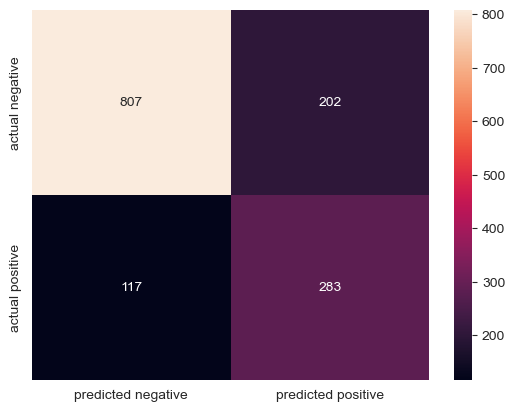

In [24]:
conf_matrix(test_results)

In [25]:
## Train

print(metrics.classification_report(y_train,X_train['y_pred']))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      4165
           1       0.51      0.79      0.62      1469

    accuracy                           0.75      5634
   macro avg       0.71      0.76      0.72      5634
weighted avg       0.81      0.75      0.76      5634



In [26]:
## Test

print(metrics.classification_report(y_test,X_test['y_pred']))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1009
           1       0.58      0.71      0.64       400

    accuracy                           0.77      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.79      0.77      0.78      1409



In [27]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [28]:
## Train

get_results(y_train, X_train['y_pred'])

The confusion matrix for your predictions is:
[[3066 1099]
 [ 306 1163]] 

The accuracy of your model is: 0.750621228257011
The recall of your model is: 0.7916950306330838
The precision of your model is: 0.5141467727674625
The F1-score of your model is: 0.6234253551326723


In [29]:
## Test
get_results(y_test, X_test['y_pred'])

The confusion matrix for your predictions is:
[[807 202]
 [117 283]] 

The accuracy of your model is: 0.7735982966643009
The recall of your model is: 0.7075
The precision of your model is: 0.5835051546391753
The F1-score of your model is: 0.6395480225988701


In [31]:
a1=pd.DataFrame(columns=['i','accuracy','prec','recall'])

c1=X_train['prob_churn'].copy()
c1 = c1.to_frame()

for i in np.arange(0, 1, 0.1):
    c1['predict']=np.where(c1['prob_churn']>i,1,0)
    b1={'i':i,'accuracy':metrics.accuracy_score(y_train, c1['predict']),'prec':metrics.precision_score(y_train, c1['predict']),'recall':metrics.recall_score(y_train, c1['predict']),'f1':metrics.f1_score(y_train, c1['predict'])}
    a1=a1.append(b1, ignore_index=True)

a1['mean']=a1.mean(axis=1)
a1=a1.sort_values(['mean'],ascending=False)

a1.head(20)

C:\Users\44796\AppData\Local\Temp\ipykernel_17612\3826784237.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a1=a1.append(b1, ignore_index=True)
C:\Users\44796\AppData\Local\Temp\ipykernel_17612\3826784237.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a1=a1.append(b1, ignore_index=True)
C:\Users\44796\AppData\Local\Temp\ipykernel_17612\3826784237.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a1=a1.append(b1, ignore_index=True)
C:\Users\44796\AppData\Local\Temp\ipykernel_17612\3826784237.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a1=a1.append(b1, ignore_index=True)
C:\Users\44796\AppData\Local\Temp\ipykernel_1761

,i,accuracy,prec,recall,f1,mean
7,0.7,0.800319,0.630898,0.564329,0.595760,0.658261
6,0.6,0.782393,0.566069,0.708645,0.629383,0.657298
8,0.8,0.796770,0.696126,0.391423,0.501089,0.637082
5,0.5,0.750621,0.514147,0.791695,0.623425,0.635978
4,0.4,0.708378,0.468433,0.878829,0.611124,0.613353
3,0.3,0.647320,0.420455,0.931926,0.579471,0.575834
9,0.9,0.762158,0.856354,0.105514,0.187879,0.562381
2,0.2,0.581292,0.379989,0.959156,0.544331,0.532954
1,0.1,0.480476,0.332951,0.989108,0.498200,0.480147
0,0.0,0.260738,0.260738,1.000000,0.413628,0.387021
